<a href="https://colab.research.google.com/github/TheCaveOfAdullam/Bethel/blob/main/kdTest2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 지식 증류 기반 CNN 모델 경량화 전체 코드 (초기 모델 포함)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch_pruning
!pip install ptflops
!pip install fvcore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
import os
import random
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# -------------------------------
# 설정: 시드 고정 및 디바이스 설정
# -------------------------------
seed = 50
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 기본 경로 설정
base_dir = '/content/drive/MyDrive/ship_motor30'
categories = ['normal', 'fault_BB', 'fault_RI', 'fault_SM']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로드 및 전처리 함수 정의
class VibrationDataset(Dataset):
    def __init__(self, base_dir, split, categories, label_encoder, segment_length=4000, transform=None):
        self.X = []
        self.y = []
        self.transform = transform
        self.segment_length = segment_length
        self.file_count = defaultdict(int)  # 카테고리별 파일 개수를 저장할 딕셔너리

        split_dir = os.path.join(base_dir, split)
        for category in categories:
            category_dir = os.path.join(split_dir, category)
            files = os.listdir(category_dir)
            self.file_count[category] = len(files)  # 카테고리별 파일 수 저장

            for file in files:
                file_path = os.path.join(category_dir, file)
                data = pd.read_csv(file_path, header=None, skiprows=1)  # 첫 행 건너뜀

                # 첫 번째 열(시간 데이터)을 제외하고 주파수 데이터만 선택
                frequency_data = data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').fillna(0).values

                # 데이터를 세그먼트로 분할
                num_segments = frequency_data.shape[0] // self.segment_length
                for i in range(num_segments):
                    segment = frequency_data[i * self.segment_length:(i + 1) * self.segment_length]
                    self.X.append(segment)  # 주파수 데이터만 포함
                    self.y.append(label_encoder.transform([category])[0])

        # 카테고리별 파일 개수 출력
        print(f"File count for '{split}' split:")
        for category, count in self.file_count.items():
            print(f"  {category}: {count} files")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx].T  # 2D 입력 (채널, 길이)로 변경
        y = self.y[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# 레이블 인코딩
label_encoder = LabelEncoder()
label_encoder.fit(categories)

# 데이터셋 준비
train_dataset = VibrationDataset(base_dir, 'train', categories, label_encoder)
val_dataset = VibrationDataset(base_dir, 'validation', categories, label_encoder)
test_dataset = VibrationDataset(base_dir, 'test', categories, label_encoder)

# 데이터 로더
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 첫 번째 데이터의 크기를 이용해 input_length 결정
first_sample, _ = train_dataset[0]
input_length = first_sample.shape[1]  # X는 (채널, 길이) 형태이므로 길이는 첫 번째 데이터의 두 번째 차원
print(f"Input length for one sample: {input_length}")

File count for 'train' split:
  normal: 2100 files
  fault_BB: 2100 files
  fault_RI: 2100 files
  fault_SM: 2100 files
File count for 'validation' split:
  normal: 450 files
  fault_BB: 450 files
  fault_RI: 450 files
  fault_SM: 450 files
File count for 'test' split:
  normal: 450 files
  fault_BB: 450 files
  fault_RI: 450 files
  fault_SM: 450 files
Input length for one sample: 4000


In [ ]:
# -------------------------------
# Teacher 모델 정의 (CNN)
# -------------------------------
class CNNModel(nn.Module):
    def __init__(self, input_length, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 16, 16)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(64, 32, 3)
        self.conv3 = nn.Conv1d(32, 64, 5)
        self.conv4 = nn.Conv1d(64, 128, 5)
        self.pool2 = nn.MaxPool1d(2)

        with torch.no_grad():
            dummy = torch.zeros(1, 1, input_length)
            x = self.pool1(torch.relu(self.conv1(dummy)))
            x = torch.relu(self.conv2(x))
            x = torch.relu(self.conv3(x))
            x = self.pool2(torch.relu(self.conv4(x)))
            self.flatten_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flatten_size, 5000)
        self.fc2 = nn.Linear(5000, 1000)
        self.fc3 = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.pool2(torch.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# -------------------------------
# Student 모델 정의
# -------------------------------
class StudentCNNModel(nn.Module):
    def __init__(self, input_length, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, 16, 16)  # 64 → 32
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 16, 3)      # 32 → 16
        self.conv3 = nn.Conv1d(16, 32, 5)      # 64 → 32
        self.conv4 = nn.Conv1d(32, 64, 5)      # 128 → 64
        self.pool2 = nn.MaxPool1d(2)

        # Flatten size 계산
        with torch.no_grad():
            dummy = torch.zeros(1, 1, input_length)
            x = self.pool1(torch.relu(self.conv1(dummy)))
            x = torch.relu(self.conv2(x))
            x = torch.relu(self.conv3(x))
            x = self.pool2(torch.relu(self.conv4(x)))
            self.flatten_size = x.view(1, -1).shape[1]

        # FC 레이어 축소
        self.fc1 = nn.Linear(self.flatten_size, 2000)  # 5000 → 2000
        self.fc2 = nn.Linear(2000, 500)                 # 1000 → 500
        self.fc3 = nn.Linear(500, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.pool2(torch.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# -------------------------------
# 학습 도우미 함수
# -------------------------------
def distillation_loss(student_logits, teacher_logits, labels, T=4.0, alpha=0.7):
    soft_loss = nn.KLDivLoss(reduction="batchmean")(nn.functional.log_softmax(student_logits / T, dim=1),
                                                    nn.functional.softmax(teacher_logits / T, dim=1))
    hard_loss = nn.CrossEntropyLoss()(student_logits, labels)
    return alpha * hard_loss + (1 - alpha) * (T * T) * soft_loss

def evaluate_model(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_val_loss = val_loss / len(loader)
    val_accuracy = 100 * correct / total

    return average_val_loss, val_accuracy


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, max_norm=1.0):
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for inputs, labels in train_loader_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_loader_iter.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # 학습 곡선 시각화
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

    return model

In [ ]:
# -------------------------------
# 지식 증류 기반 Student 모델 학습 함수
# -------------------------------
def train_kd(student_model, teacher_model, train_loader, val_loader, optimizer, num_epochs=10, T=4.0, alpha=0.7):
    student_model.to(device)
    teacher_model.to(device)
    teacher_model.eval()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        student_model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_loader_iter = tqdm(train_loader, desc=f"KD Epoch {epoch+1}/{num_epochs}", unit="batch")

        for inputs, labels in train_loader_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)
            student_outputs = student_model(inputs)
            loss = distillation_loss(student_outputs, teacher_outputs, labels, T=T, alpha=alpha)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(student_model.parameters(), 1.0)
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(student_outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_loader_iter.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = evaluate_model(student_model, val_loader, nn.CrossEntropyLoss())
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"KD Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('KD - Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('KD - Training and Validation Accuracy')
    plt.legend()

    plt.show()

    return student_model

In [ ]:
# 모델 크기 계산
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    model_size = (param_size + buffer_size) / 1024**2  # Convert to MB
    return model_size

In [ ]:
input_length = input_length
num_classes = len(categories)

teacher_model = CNNModel(input_length, num_classes).to(device)
student_model = StudentCNNModel(input_length, num_classes).to(device)

Epoch 1/10: 100%|██████████| 788/788 [00:28<00:00, 27.29batch/s, accuracy=24.6, loss=1.39]


Epoch [1/10], Loss: 1.3865, Accuracy: 24.62%, Val Loss: 1.3864, Val Accuracy: 25.00%


Epoch 2/10: 100%|██████████| 788/788 [00:27<00:00, 29.00batch/s, accuracy=26.2, loss=1.38]


Epoch [2/10], Loss: 1.3861, Accuracy: 26.17%, Val Loss: 1.3843, Val Accuracy: 25.00%


Epoch 3/10: 100%|██████████| 788/788 [00:27<00:00, 28.80batch/s, accuracy=45.2, loss=1.02]


Epoch [3/10], Loss: 1.2479, Accuracy: 45.23%, Val Loss: 0.9675, Val Accuracy: 50.00%


Epoch 4/10: 100%|██████████| 788/788 [00:27<00:00, 28.73batch/s, accuracy=73.1, loss=0.502]


Epoch [4/10], Loss: 0.7969, Accuracy: 73.08%, Val Loss: 0.7059, Val Accuracy: 74.91%


Epoch 5/10: 100%|██████████| 788/788 [00:27<00:00, 28.72batch/s, accuracy=83.1, loss=0.655]


Epoch [5/10], Loss: 0.6361, Accuracy: 83.08%, Val Loss: 0.5496, Val Accuracy: 88.28%


Epoch 6/10: 100%|██████████| 788/788 [00:27<00:00, 28.76batch/s, accuracy=88.8, loss=0.5]


Epoch [6/10], Loss: 0.4998, Accuracy: 88.85%, Val Loss: 0.4394, Val Accuracy: 94.80%


Epoch 7/10: 100%|██████████| 788/788 [00:27<00:00, 28.81batch/s, accuracy=94.8, loss=0.204]


Epoch [7/10], Loss: 0.3810, Accuracy: 94.76%, Val Loss: 0.3079, Val Accuracy: 97.30%


Epoch 8/10: 100%|██████████| 788/788 [00:27<00:00, 28.75batch/s, accuracy=97.2, loss=0.302]


Epoch [8/10], Loss: 0.2734, Accuracy: 97.19%, Val Loss: 0.2446, Val Accuracy: 97.37%


Epoch 9/10: 100%|██████████| 788/788 [00:27<00:00, 28.73batch/s, accuracy=98, loss=0.177]


Epoch [9/10], Loss: 0.2066, Accuracy: 97.97%, Val Loss: 0.1786, Val Accuracy: 98.52%


Epoch 10/10: 100%|██████████| 788/788 [00:27<00:00, 28.80batch/s, accuracy=98.8, loss=0.141]


Epoch [10/10], Loss: 0.1521, Accuracy: 98.85%, Val Loss: 0.1569, Val Accuracy: 97.11%


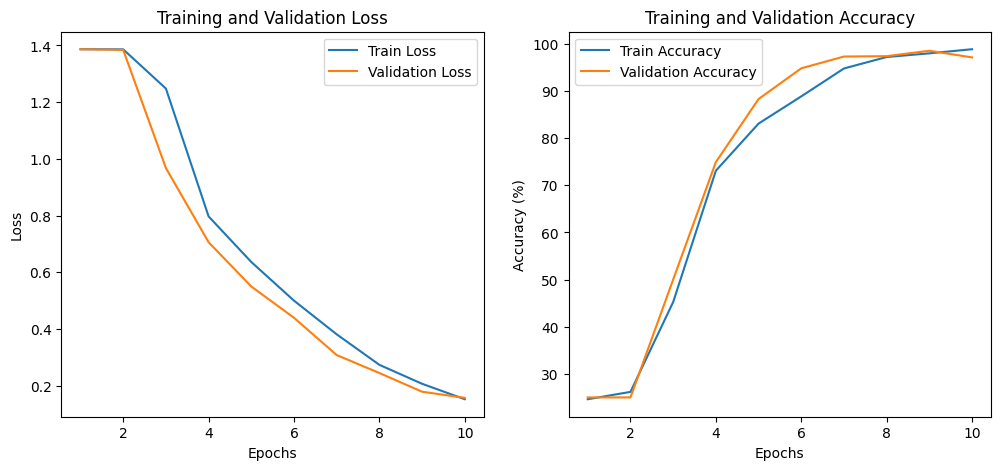

In [ ]:
# 교사 모델 학습
criterion = nn.CrossEntropyLoss()
teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=0.00001, weight_decay=1e-4)
teacher_model = train_model(teacher_model, train_loader, val_loader, criterion, teacher_optimizer, num_epochs=10)

In [ ]:
# 모델 크기 출력
model_size = get_model_size(teacher_model)
print(f'Model size: {model_size:.2f} MB')

Model size: 158.50 MB


KD Epoch 1/10: 100%|██████████| 788/788 [00:15<00:00, 50.69batch/s, accuracy=25.2, loss=3.16]


KD Epoch [1/10], Loss: 3.1946, Accuracy: 25.19%, Val Loss: 1.3879, Val Accuracy: 25.00%


KD Epoch 2/10: 100%|██████████| 788/788 [00:15<00:00, 51.06batch/s, accuracy=25, loss=2.88]


KD Epoch [2/10], Loss: 3.1941, Accuracy: 25.00%, Val Loss: 1.3876, Val Accuracy: 25.00%


KD Epoch 3/10: 100%|██████████| 788/788 [00:15<00:00, 50.93batch/s, accuracy=25, loss=3.02]


KD Epoch [3/10], Loss: 3.1937, Accuracy: 25.00%, Val Loss: 1.3870, Val Accuracy: 25.00%


KD Epoch 4/10: 100%|██████████| 788/788 [00:15<00:00, 50.92batch/s, accuracy=25.6, loss=3.34]


KD Epoch [4/10], Loss: 3.1918, Accuracy: 25.65%, Val Loss: 1.3833, Val Accuracy: 50.00%


KD Epoch 5/10: 100%|██████████| 788/788 [00:15<00:00, 50.43batch/s, accuracy=37.4, loss=2.71]


KD Epoch [5/10], Loss: 3.1437, Accuracy: 37.44%, Val Loss: 1.2956, Val Accuracy: 50.00%


KD Epoch 6/10: 100%|██████████| 788/788 [00:15<00:00, 50.72batch/s, accuracy=50, loss=2.05]


KD Epoch [6/10], Loss: 2.7259, Accuracy: 50.00%, Val Loss: 0.9679, Val Accuracy: 50.00%


KD Epoch 7/10: 100%|██████████| 788/788 [00:15<00:00, 50.68batch/s, accuracy=53.4, loss=1.44]


KD Epoch [7/10], Loss: 1.8640, Accuracy: 53.41%, Val Loss: 0.7529, Val Accuracy: 71.76%


KD Epoch 8/10: 100%|██████████| 788/788 [00:15<00:00, 50.90batch/s, accuracy=85.9, loss=1.06]


KD Epoch [8/10], Loss: 1.1290, Accuracy: 85.94%, Val Loss: 0.5702, Val Accuracy: 98.09%


KD Epoch 9/10: 100%|██████████| 788/788 [00:15<00:00, 50.35batch/s, accuracy=90.5, loss=0.664]


KD Epoch [9/10], Loss: 0.7518, Accuracy: 90.51%, Val Loss: 0.4416, Val Accuracy: 95.28%


KD Epoch 10/10: 100%|██████████| 788/788 [00:15<00:00, 50.70batch/s, accuracy=95, loss=0.357]


KD Epoch [10/10], Loss: 0.5295, Accuracy: 94.98%, Val Loss: 0.3325, Val Accuracy: 99.52%


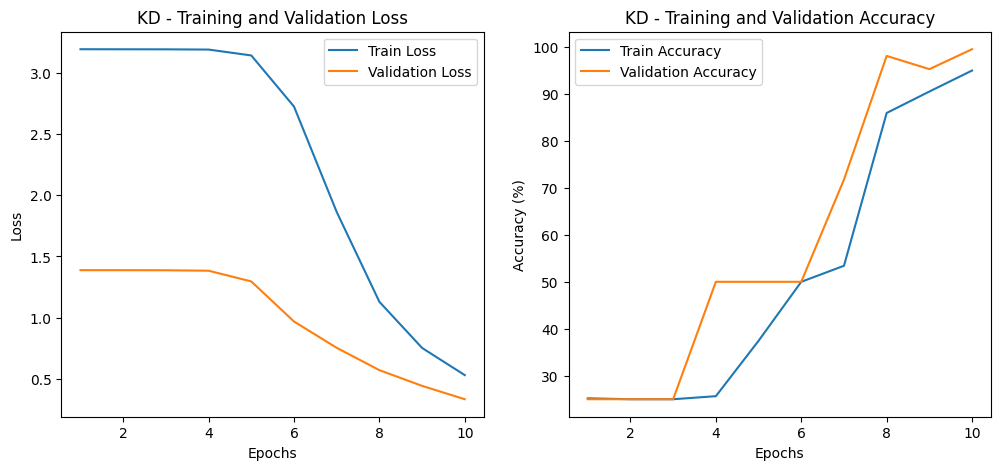

In [ ]:
# 학생 모델 학습 (KD)
student_optimizer = optim.Adam(student_model.parameters(), lr=0.00001, weight_decay=1e-5)
student_model = train_kd(student_model, teacher_model, train_loader, val_loader, student_optimizer, num_epochs=10, T=4.0, alpha=0.7)

In [ ]:
# 최종 테스트 정확도 출력
final_loss, final_accuracy = evaluate_model(student_model, test_loader, nn.CrossEntropyLoss())
print(f"\n[Student Model Test Accuracy] {final_accuracy:.2f}%")


[Student Model Test Accuracy] 99.78%


In [ ]:
# 모델 크기 출력
model_size = get_model_size(student_model)
print(f'Model size: {model_size:.2f} MB')

Model size: 31.72 MB
